In [1]:
import sqlite3
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

SQL_LITE_DB_PATH = "D:\\Repos\\ut-health\\mimic-iii-gz\\mimic3.db"
CREATE_PYVIS_GRAPHS = False

# connect to the SQLite database in the file at the given path d:\data\mimic.db
conn = sqlite3.connect(SQL_LITE_DB_PATH)

# print version of sqlite
cursor = conn.cursor()
cursor.execute("SELECT sqlite_version()")
print(f"SQLite version: {cursor.fetchone()}")

# close connection
conn.close()

# print versions
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"NetworkX version: {nx.__version__}")

# set pandas display options to show all columns and rows without truncation
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
print("\nRemoved truncation of columns")

SQLite version: ('3.49.1',)
Pandas version: 2.2.3
Matplotlib version: 3.10.1
NetworkX version: 3.4.2

Removed truncation of columns


# Load Data

In [2]:
# load patient data
conn = sqlite3.connect(SQL_LITE_DB_PATH)

query = "SELECT * FROM patients"
patients_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM d_icd_diagnoses"
d_icd_diagnoses_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM diagnoses_icd"
diagnoses_icd_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM admissions"
admissions_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM procedures_icd"
procedures_icd_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM d_icd_procedures"
d_icd_procedures_df = pd.read_sql_query(query, conn)

conn.close()

# Downsample to reduce data size
Reduces the number of patients, picks the latest admission (hadm_id) for the patient and picks only those diagnoses belonging to the hospital admission.

In [3]:
# print the number of patients and diagnoses
print(f"Patients count: {len(patients_df)}")
print(f"Admissions count: {len(admissions_df)}")
print(f"Diagnoses count: {len(diagnoses_icd_df)}")
print(f"Procedures count: {len(procedures_icd_df)}")

# patient fraction of the full 46k patient dataframe to select for processing
pt_frac = 0.0001  # gives 5 patients, 52 diagnoses
pt_frac = 0.0002  # gives 9 patients, 110 diagnoses
pt_frac = 0.0003  # gives 14 patients, 188 diagnoses
pt_frac = 0.0015  # gives 70 patients, 813 diagnoses
pt_frac = 0.01    # gives 465 patients, 5085 diagnoses
pt_frac = 0.02    # gives 930 patients, 9939 diagnoses
pt_frac = 0.05    # gives 2326 patients, 24959 diagnoses

pt_frac = 0.25

# select 0.01% of the patients randomly
patients_df = patients_df.sample(frac=pt_frac, random_state=1)

# merge with admissions and add DOB to admissions_df
admissions_df = admissions_df.merge(patients_df[['SUBJECT_ID', 'DOB']], left_on='SUBJECT_ID', right_on='SUBJECT_ID', how='inner', suffixes=('_adm', '_pt'))

# sort admissions_df by SUBJECT_ID and ADMITTIME in ascending order
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df = admissions_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])

# keep the newest admission (HADM_ID) for each patient, drop the rest of the admissions
admissions_df = admissions_df.groupby('SUBJECT_ID').last().reset_index()

# keep only diagnoses that belong to HADM_IDs in admissions_df
diagnoses_icd_df = diagnoses_icd_df[diagnoses_icd_df['HADM_ID'].isin(admissions_df['HADM_ID'])]

# keep only procedures that belong to HADM_IDs in admissions_df
procedures_icd_df = procedures_icd_df[procedures_icd_df['HADM_ID'].isin(admissions_df['HADM_ID'])]

# print the number of patients and diagnoses
print(f"Updated patient count: {len(patients_df)}")
print(f"Updated admissions count: {len(admissions_df)}")
print(f"Updated diagnoses count: {len(diagnoses_icd_df)}, unique diagnoses: {len(diagnoses_icd_df['ICD9_CODE'].unique())}")
print(f"Updated procedures count: {len(procedures_icd_df)}, unique procedures: {len(procedures_icd_df['ICD9_CODE'].unique())}")

Patients count: 46520
Admissions count: 58976
Diagnoses count: 651047
Procedures count: 240095
Updated patient count: 11630
Updated admissions count: 11630
Updated diagnoses count: 123987, unique diagnoses: 4680
Updated procedures count: 47150, unique procedures: 1344


# Feature Engineering
Create age bucket and add hadm_id to patients dataframe

In [4]:
print(f"Patient count: {len(patients_df)}")

# convert to integer from datetime type to calculate age (without overflow)
admissions_df['DOB'] = admissions_df['DOB'].astype('datetime64[s]').astype(int)
admissions_df['ADMITTIME'] = admissions_df['ADMITTIME'].astype('datetime64[s]').astype(int)

# calculate age at admission
admissions_df['AGE'] = (admissions_df['ADMITTIME'] - admissions_df['DOB']) / 86400 / 365

# create age intervals in 5 year increments, of type int
admissions_df['AGE_BUCKET'] = (admissions_df['AGE'] // 5).astype(int) * 5

# set age bucket to 95 where age is greater than 90
admissions_df.loc[admissions_df['AGE_BUCKET'] > 90, 'AGE_BUCKET'] = 95

# add AGE_BUCKET to patients_df
patients_df = patients_df.merge(admissions_df[['SUBJECT_ID', 'HADM_ID', 'AGE_BUCKET']], left_on='SUBJECT_ID', right_on='SUBJECT_ID', how='inner', suffixes=('_pt', '_adm'))

# keep only the relevant columns in patients_df
patients_df = patients_df[['SUBJECT_ID', 'HADM_ID', 'GENDER', 'AGE_BUCKET', 'EXPIRE_FLAG']]

print(f"Updated patient count (with age bucket): {len(patients_df)}")

Patient count: 11630
Updated patient count (with age bucket): 11630


# Create network graph

## Create nodes: patients

In [5]:
# Create a graph
G = nx.MultiGraph()
print(f"Nodes count in graph: {G.number_of_nodes()}")

for _, row in patients_df.iterrows():

    # Add a node with the patient ID as the node identifier and gender as an attribute, also add dob as an attribute
    G.add_node(f"patient-{row['SUBJECT_ID']}", gender=row['GENDER'], age_bucket=row['AGE_BUCKET'], hadm_id=row['HADM_ID'], type='patient')

# number of nodes in the graph
print(f"Updated node count in graph: {G.number_of_nodes()}")

Nodes count in graph: 0
Updated node count in graph: 11630


## Create nodes + edges: diagnoses and patient -> diagnoses

In [6]:
print(f"Diagnoses row count pre-merge: {len(diagnoses_icd_df)}")

# merge diagnoses with d_icd_diagnoses to get the description of the diagnosis
diagnoses_icd_df = diagnoses_icd_df.merge(d_icd_diagnoses_df[['ICD9_CODE', 'SHORT_TITLE']], left_on='ICD9_CODE', right_on='ICD9_CODE', how='left', suffixes=('_diag', '_desc'))

# Check if the merge was successful and print the number of rows in the merged DataFrame
print(f"Diagnoses row count post-merge: {len(diagnoses_icd_df)}")

Diagnoses row count pre-merge: 123987
Diagnoses row count post-merge: 123987


In [7]:
diagnoses_icd_df.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,SHORT_TITLE
0,1556,119,135738,1.0,88122,Opn wound wrist w tendon
1,1557,119,135738,2.0,9032,Injury radial vessels


In [8]:
# number of nodes in the graph
n_count = G.number_of_nodes()
print(f"Node count in graph: {n_count}")

# do an inplace sort asending by HADM_ID and SEQ_NUM
diagnoses_icd_df.sort_values(by=['HADM_ID', 'SEQ_NUM'], inplace=True)
i=0
# Create nodes for diagnoses and connect them to patients
for _, row in diagnoses_icd_df.iterrows():

    # create unique name to prevent clashes with other node id
    diag_node_id = f'diagnosis-{row["ICD9_CODE"]}'

    # add the diagnosis as a node
    if not G.has_node(diag_node_id):
        G.add_node(diag_node_id, name=row['SHORT_TITLE'], code=row['ICD9_CODE'], type='diagnosis')
    
    # Connect the patient to this diagnosis
    patient_id = f"patient-{row['SUBJECT_ID']}"
    G.add_edge(patient_id, diag_node_id, relation='has_diagnosis', seq_num=row['SEQ_NUM'])

# Print updated graph stats
print(f"Diagnosis nodes added: {G.number_of_nodes() - n_count}")
print(f"Edges count in graph: {G.number_of_edges()}")
print(f"Updated node count in graph: {G.number_of_nodes()}")

Node count in graph: 11630
Diagnosis nodes added: 4680
Edges count in graph: 123987
Updated node count in graph: 16310


## Create nodes + edges: procedures and patient -> procedures

In [9]:
# count before merge
print(f"Procedures count pre-merge: {len(procedures_icd_df)}")

# merge procedures with d_icd_procedures to get the description of the procedure
procedures_icd_df = procedures_icd_df.merge(d_icd_procedures_df[['ICD9_CODE', 'SHORT_TITLE']], left_on='ICD9_CODE', right_on='ICD9_CODE', how='left', suffixes=('_proc', '_desc'))

print(f"Procedures count post-merge: {len(procedures_icd_df)}")

Procedures count pre-merge: 47150
Procedures count post-merge: 48741


In [10]:
# number of nodes in the graph before adding procedures
n_count = G.number_of_nodes()
print(f"Node count in graph before adding procedures: {n_count}")

# do an inplace sort ascending by HADM_ID and SEQ_NUM
procedures_icd_df.sort_values(by=['HADM_ID', 'SEQ_NUM'], inplace=True)

# Create nodes for procedures and connect them to patients
for _, row in procedures_icd_df.iterrows():
    # create unique name to prevent clashes with other node ids
    proc_node_id = f'procedure-{row["ICD9_CODE"]}'
    
    # add the procedure as a node if it doesn't already exist
    if not G.has_node(proc_node_id):
        G.add_node(proc_node_id, name=row['SHORT_TITLE'], code=row['ICD9_CODE'], type='procedure')
    
    # Connect the patient to this procedure
    patient_id = f"patient-{row['SUBJECT_ID']}"
    G.add_edge(patient_id, proc_node_id, relation='has_procedure', seq_num=row['SEQ_NUM'])

# Print updated graph stats
print(f"Procedure nodes added: {G.number_of_nodes() - n_count}")
print(f"Edges count in graph: {G.number_of_edges()}")
print(f"Updated node count in graph: {G.number_of_nodes()}")

Node count in graph before adding procedures: 16310
Procedure nodes added: 1344
Edges count in graph: 172728
Updated node count in graph: 17654


# Network Graph Statistics

In [11]:
# print the number of each type of node
node_types = {data.get('type'): 0 for _, data in G.nodes(data=True)}
for _, data in G.nodes(data=True):
    node_type = data.get('type')
    node_types[node_type] += 1

print("Node counts by type:")
for node_type, count in node_types.items():
    print(f"\t{node_type}: {count}")

# print edge types
edge_types = {data.get('relation'): 0 for _, _, data in G.edges(data=True)}
for _, _, data in G.edges(data=True):
    edge_type = data.get('relation')
    edge_types[edge_type] += 1

print("\nEdge counts by type:")
for edge_type, count in edge_types.items():
    print(f"\t{edge_type}: {count}")

Node counts by type:
	patient: 11630
	diagnosis: 4680
	procedure: 1344

Edge counts by type:
	has_diagnosis: 123987
	has_procedure: 48741


# Similarity Data
Similarity data is used as the validation set by R-GCN neural networks

## Jaccard Similarity

Total patient nodes: 11630
Total diagnosis nodes: 4680
Total procedure nodes: 1344
Diagnosis matrix shape: (11630, 4680)
Procedure matrix shape: (11630, 1344)
Combined matrix shape: (11630, 6024)

Combined Features Similarity Data Summary:
Total pairs analyzed: 67622635
Positive pairs (similar patients): 644201
Negative pairs (dissimilar patients): 644201
Final validation set size: 1288402

Similarity Distribution:
count    6.762264e+07
mean     3.022615e-02
std      6.253787e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.166667e-02
max      1.000000e+00
Name: jaccard_similarity, dtype: float64


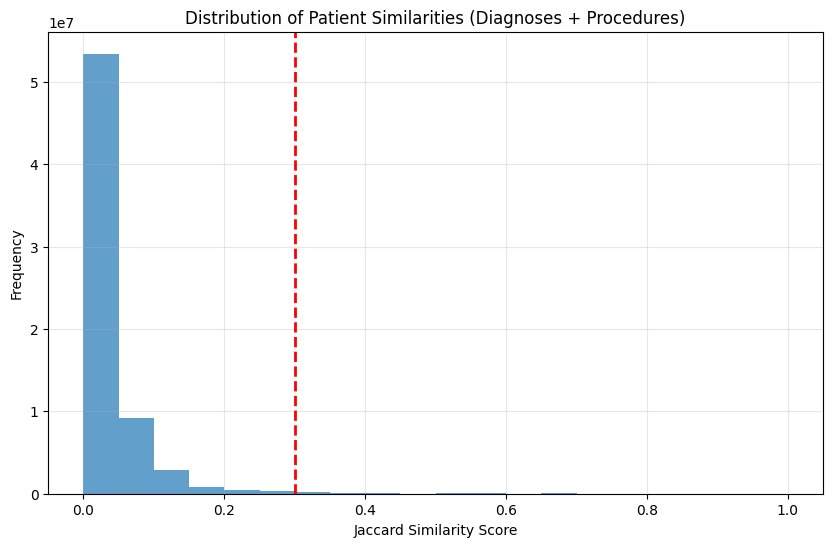


Combined features validation data ready for model evaluation


In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse

# Get all patient nodes and their connected diagnoses and procedures
patient_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'patient']
diagnosis_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'diagnosis']
procedure_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'procedure']

print(f"Total patient nodes: {len(patient_nodes)}")
print(f"Total diagnosis nodes: {len(diagnosis_nodes)}")
print(f"Total procedure nodes: {len(procedure_nodes)}")

# Create mapping from node IDs to indices for efficient lookup
patient_to_idx = {patient: i for i, patient in enumerate(patient_nodes)}
diagnosis_to_idx = {diagnosis: i for i, diagnosis in enumerate(diagnosis_nodes)}
procedure_to_idx = {procedure: i for i, procedure in enumerate(procedure_nodes)}

# Create sparse matrices for patient-diagnosis and patient-procedure connections
# For diagnoses
diag_rows, diag_cols = [], []
for patient in patient_nodes:
    for neighbor in G.neighbors(patient):
        if 'diagnosis' in neighbor:
            diag_rows.append(patient_to_idx[patient])
            diag_cols.append(diagnosis_to_idx[neighbor])

# For procedures
proc_rows, proc_cols = [], []
for patient in patient_nodes:
    for neighbor in G.neighbors(patient):
        if 'procedure' in neighbor:
            proc_rows.append(patient_to_idx[patient])
            proc_cols.append(procedure_to_idx[neighbor])

# Create sparse matrices
diag_data = np.ones(len(diag_rows), dtype=np.int8)
diag_matrix = sparse.csr_matrix((diag_data, (diag_rows, diag_cols)), 
                              shape=(len(patient_nodes), len(diagnosis_nodes)))

proc_data = np.ones(len(proc_rows), dtype=np.int8)
proc_matrix = sparse.csr_matrix((proc_data, (proc_rows, proc_cols)), 
                              shape=(len(patient_nodes), len(procedure_nodes)))

# Combine the two matrices horizontally for a unified feature representation
combined_matrix = sparse.hstack([diag_matrix, proc_matrix])

print(f"Diagnosis matrix shape: {diag_matrix.shape}")
print(f"Procedure matrix shape: {proc_matrix.shape}")
print(f"Combined matrix shape: {combined_matrix.shape}")

# Calculate dot product for intersection
intersection = combined_matrix.dot(combined_matrix.T)

# Compute features per patient (sum of diagnoses and procedures)
patient_feature_counts = np.array(combined_matrix.sum(axis=1)).flatten()

# Calculate jaccard similarities
intersection_dense = intersection.toarray()
union_dense = np.zeros_like(intersection_dense)

for i in range(len(patient_nodes)):
    for j in range(i, len(patient_nodes)):  # Upper triangular is enough due to symmetry
        union_value = patient_feature_counts[i] + patient_feature_counts[j] - intersection_dense[i, j]
        union_dense[i, j] = union_value
        union_dense[j, i] = union_value  # Matrix is symmetric

# Calculate Jaccard similarity (intersection / union)
jaccard_matrix = np.zeros_like(intersection_dense, dtype=float)
nonzero_mask = union_dense > 0
jaccard_matrix[nonzero_mask] = intersection_dense[nonzero_mask] / union_dense[nonzero_mask]

# Get patient data for additional metrics
patient_info = {}
for patient in patient_nodes:
    subject_id = int(patient.split('-')[1])
    patient_data = patients_df[patients_df['SUBJECT_ID'] == subject_id].iloc[0]
    patient_info[patient] = {
        'gender': patient_data['GENDER'],
        'age_bucket': patient_data['AGE_BUCKET']
    }

# Create DataFrame from similarity matrix
similarity_data = []
for i in range(len(patient_nodes)):
    for j in range(i+1, len(patient_nodes)):  # Only upper triangle to avoid duplicates
        p1 = patient_nodes[i]
        p2 = patient_nodes[j]
        p1_id = int(p1.split('-')[1])
        p2_id = int(p2.split('-')[1])
        
        # Get similarity score
        sim_score = jaccard_matrix[i, j]
        
        # Check if they have the same gender and age bucket
        same_gender = patient_info[p1]['gender'] == patient_info[p2]['gender']
        same_age_bucket = patient_info[p1]['age_bucket'] == patient_info[p2]['age_bucket']
        
        similarity_data.append({
            'patient1': p1,
            'patient2': p2,
            'patient1_id': p1_id,
            'patient2_id': p2_id,
            'jaccard_similarity': sim_score,
            'same_gender': same_gender,
            'same_age_bucket': same_age_bucket
        })

# Convert to DataFrame
combined_similarity_df = pd.DataFrame(similarity_data)

# Define positive and negative pairs based on similarity threshold
similarity_threshold = 0.3
combined_similarity_df['is_similar'] = combined_similarity_df['jaccard_similarity'] >= similarity_threshold

# Create validation sets
positive_pairs = combined_similarity_df[combined_similarity_df['is_similar']].copy()
negative_pairs = combined_similarity_df[~combined_similarity_df['is_similar']].copy()

# Balance the dataset
min_count = min(len(positive_pairs), len(negative_pairs))
if min_count < len(positive_pairs):
    positive_pairs = positive_pairs.sample(min_count, random_state=42)
if min_count < len(negative_pairs):
    negative_pairs = negative_pairs.sample(min_count, random_state=42)

# Combine into final validation set
validation_pairs_combined = pd.concat([positive_pairs, negative_pairs])

# Print summary statistics
print(f"\nCombined Features Similarity Data Summary:")
print(f"Total pairs analyzed: {len(combined_similarity_df)}")
print(f"Positive pairs (similar patients): {len(positive_pairs)}")
print(f"Negative pairs (dissimilar patients): {len(negative_pairs)}")
print(f"Final validation set size: {len(validation_pairs_combined)}")

# Show similarity distribution
print("\nSimilarity Distribution:")
print(combined_similarity_df['jaccard_similarity'].describe())

# Create a histogram of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(combined_similarity_df['jaccard_similarity'], bins=20, alpha=0.7)
plt.axvline(similarity_threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Patient Similarities (Diagnoses + Procedures)')
plt.xlabel('Jaccard Similarity Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Save combined validation pairs
validation_pairs_combined.to_csv('patient_similarity_combined_validation_pairs.csv', index=False)

print("\nCombined features validation data ready for model evaluation")

In [25]:
# show the last 5 rows of the validation pairs dataframe
validation_pairs_combined.head(5)

,patient1,patient2,patient1_id,patient2_id,jaccard_similarity,same_gender,same_age_bucket,is_similar
423,patient-4074,patient-10139,4074,10139,0.304348,False,False,True
9670,patient-4074,patient-26572,4074,26572,0.300000,True,True,True
16410,patient-90889,patient-84020,90889,84020,0.344828,True,False,True
17072,patient-90889,patient-67648,90889,67648,0.400000,False,False,True
19221,patient-90889,patient-6138,90889,6138,0.333333,True,False,True


# Pickle and persist

In [23]:
import os

CURR_DIR_PATH = os.getcwd()

PICKLE_GRAPH_FILE_NAME = None
PICKLE_SIMILARITY_FILE_NAME = None
HTML_FILE_NAME = None

if G.number_of_nodes() < 10:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_10_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_10_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_10_nodes.html"

elif G.number_of_nodes() < 50:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_50_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_50_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_50_nodes.html"

elif G.number_of_nodes() < 100:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_100_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_100_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_100_nodes.html"

elif G.number_of_nodes() < 1000:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_1000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_1000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_1000_nodes.html"

elif G.number_of_nodes() < 10000:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_10000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_10000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_10000_nodes.html"

elif G.number_of_nodes() < 15000:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_15000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_15000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_15000_nodes.html"

elif G.number_of_nodes() < 20000:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_20000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_20000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_20000_nodes.html"

else:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_46000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_46000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_46000_nodes.html"

print(f"Total graph node count: {G.number_of_nodes()}")
print(f"Pickle graph file name: {PICKLE_GRAPH_FILE_NAME}")
print(f"Pickle similarity file name: {PICKLE_SIMILARITY_FILE_NAME}")
print(f"HTML file name: {HTML_FILE_NAME}")

Total graph node count: 17654
Pickle graph file name: d:\Repos\ut-health-final-proj\pickle\pickle\max_20000_nodes_graph.gpickle
Pickle similarity file name: d:\Repos\ut-health-final-proj\pickle\pickle\max_20000_nodes_similarity.gpickle
HTML file name: d:\Repos\ut-health-final-proj\pickle\pyvis\graph_max_20000_nodes.html


In [27]:
import os

CURR_DIR_PATH = os.getcwd()

PICKLE_GRAPH_FILE_NAME = None
PICKLE_SIMILARITY_FILE_NAME = None
HTML_FILE_NAME = None

if G.number_of_nodes() < 10:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\max_10_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\max_10_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_10_nodes.html"

elif G.number_of_nodes() < 50:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\max_50_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\max_50_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_50_nodes.html"

elif G.number_of_nodes() < 100:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\max_100_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\max_100_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_100_nodes.html"

elif G.number_of_nodes() < 1000:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\max_1000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\max_1000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_1000_nodes.html"

elif G.number_of_nodes() < 10000:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\max_10000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\max_10000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_10000_nodes.html"

elif G.number_of_nodes() < 15000:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\max_15000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\max_15000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_15000_nodes.html"

elif G.number_of_nodes() < 20000:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\max_20000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\max_20000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_20000_nodes.html"

else:
    PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\max_46000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\max_46000_nodes_similarity.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_46000_nodes.html"

print(f"Total graph node count: {G.number_of_nodes()}")
print(f"Pickle graph file name: {PICKLE_GRAPH_FILE_NAME}")
print(f"Pickle similarity file name: {PICKLE_SIMILARITY_FILE_NAME}")
print(f"HTML file name: {HTML_FILE_NAME}")

Total graph node count: 17654
Pickle graph file name: d:\Repos\ut-health-final-proj\pickle\max_20000_nodes_graph.gpickle
Pickle similarity file name: d:\Repos\ut-health-final-proj\pickle\max_20000_nodes_similarity.gpickle
HTML file name: d:\Repos\ut-health-final-proj\pickle\pyvis\graph_max_20000_nodes.html


In [28]:
# pickle the graph G
import pickle
with open(PICKLE_GRAPH_FILE_NAME, 'wb') as f:
    pickle.dump(G, f)
    print(f"Graph G pickled to {PICKLE_GRAPH_FILE_NAME}")

# pickle the positive similarity pairs
with open(PICKLE_SIMILARITY_FILE_NAME, 'wb') as f:
    pickle.dump(validation_pairs_combined, f)
    print(f"Similarity dataframe pickled to {PICKLE_SIMILARITY_FILE_NAME}")


Graph G pickled to d:\Repos\ut-health-final-proj\pickle\max_20000_nodes_graph.gpickle
Similarity dataframe pickled to d:\Repos\ut-health-final-proj\pickle\max_20000_nodes_similarity.gpickle
